In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve # David told me about this

from ucimlrepo import fetch_ucirepo
import pandas as pd

#Group: Aidan Cusa, Kristof Jablowski, Andrew Yuan

In [2]:
# Data generation
n = 400
true_mu1 = np.array([1, 1]) #mean for Gaussian Class A
true_mu2 = np.array([-1, -1]) #mean for Gaussian Class B
sigma = np.eye(2) #2x2

prob_A = (n/(2*n)) #prior prob for each Class in this case I put it to 50/50
prob_B = 1 - prob_A

X1 = np.random.multivariate_normal(true_mu1, sigma, n) #Class A
X2 = np.random.multivariate_normal(true_mu2, sigma, n) #Class B

X = np.vstack([X1, X2]) # 2D array of all data points
Y = np.hstack([np.ones(n), np.zeros(n)]) # Vector denoting which class each row in X belongs to

In [3]:
# Gaussian Generative Model - Assume the underlying Class samples were generated from a Gaussian Dist.
est_mu1 = X[Y==1].mean(axis=0) # Mean across all samples in Class A
est_mu2 = X[Y==0].mean(axis=0) # Mean across all samples in Class B 

# This computes posterior probability for some Class
def posterior_prob(x_data, est_mu1, est_mu2, sigma, prob_A, prob_B):
    # Quadratic terms in x from the exponents of the Gaussian densities cancel since each Class shares covariance matrix 
    # resulting in a linear function of x in the argument of the logistic sigmoid
    # sigmoid(a) = sigmoid(w^Tx + w0)
    w = np.linalg.inv(sigma) @ (est_mu1 - est_mu2) #2x1
    w0 = (-1/2)*np.transpose(est_mu1) @ np.linalg.inv(sigma) @ (est_mu1) + \
    (1/2)*np.transpose(est_mu2) @ np.linalg.inv(sigma) @ (est_mu2) + \
    np.log(prob_A/prob_B)
    
    a = x_data @ w + w0
    a = np.clip(a, -100, 100) # Numerical Stability --> way below machine epsilon otherwise I get singular matrix issues or overflow
    w_gauss = np.hstack(([w0], w))
    return w_gauss, 1/(1+np.exp(-a))

In [4]:
# Gaussian Generative Model Classification Performance
w_gauss, y_pred_raw = posterior_prob(X, est_mu1, est_mu2, sigma, prob_A, prob_B) 
y_pred = (y_pred_raw > 0.5).astype(int) # Model Classification (greater than 0.5 since its decision) 
# Make sure 0.5 is always the threshold
#Check if Classified same as true Y
accuracy = np.mean(y_pred == Y)

print(f"Gauss Gen Accuracy: {accuracy:.2f}")

Gauss Gen Accuracy: 0.91


In [5]:
# IRLS Algorithm - STILL LINEAR so no non-linear transformation applied to inputs X
def compute_weights(Phi, w_old, Y):
    a = np.clip(Phi @ w_old, -100, 100) # Numerical Stability --> way below machine epsilon otherwise I get singular matrix issues or overflow
    y_n  = 1.0 / (1.0 + np.exp(-a)) 
    # R = np.diag(y_n * (1 - y_n))
    R = np.diag(np.clip(y_n * (1 - y_n), 1e-9, None)) # Numerical Stability --> way below machine epsilon otherwise I get singular matrix issues or overflow
    z = Phi @ w_old - np.linalg.inv(R) @ (y_n-Y)
    w_new = np.linalg.inv(np.transpose(Phi) @ R @ Phi) @ np.transpose(Phi) @ R @ z
    return w_new
            
def step_IRLS(X, Y, w_old, iterations):
    Phi = np.column_stack([np.ones(X.shape[0]), X])  #n x 3 (since we have [1, x1, x2])
    
    # Iterative Alg. feeding the old weight vectors back into compute weights function
    for i in range(iterations):
        w_new = compute_weights(Phi, w_old, Y)
        # Assuming this is how we determine if we converged or not - the book didnt specify :/
        if np.linalg.norm(w_new - w_old) < 1e-6: # Common numerical jitter values are 1e-6
            print("Converged!")
            break
        w_old = w_new
        
    # Make final predictions with Class Conditional
    a = Phi @ w_new
    a = np.clip(a, -100, 100)
    y_pred_irls = 1 / (1 + np.exp(-a))
    return w_new, y_pred_irls

In [6]:
# Logistic Regression IRSL Model Performance
iterations = 20 # this is probably overkill
w_old = np.zeros(3) # initially set weight vector of size 2 + 1 to 0
w_irls, y_pred_irls_raw = step_IRLS(X, Y, w_old, iterations) # Model Classification (greater than 0.5 since its decision) 
y_pred_irls = (y_pred_irls_raw > 0.5).astype(int)

# Make sure 0.5 is always the threshold
#Check if Classified same as true Y
accuracy_irsl = np.mean(y_pred_irls == Y)

print(f"Logistic Reg Accuracy: {accuracy_irsl:.2f}")

Converged!
Logistic Reg Accuracy: 0.91


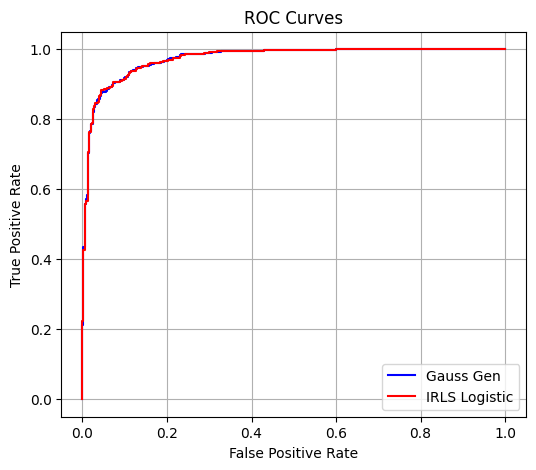

In [7]:
# Plotting ROC Curve
false_pos_gauss, true_pos_gauss, _ = roc_curve(Y, y_pred_raw)
false_pos_irls, true_pos_irls, _ = roc_curve(Y, y_pred_irls_raw)

# Plot both ROC curves
plt.figure(figsize=(6, 5))
plt.plot(false_pos_gauss, true_pos_gauss, label=f'Gauss Gen', color='blue')
plt.plot(false_pos_irls, true_pos_irls, label=f'IRLS Logistic', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()


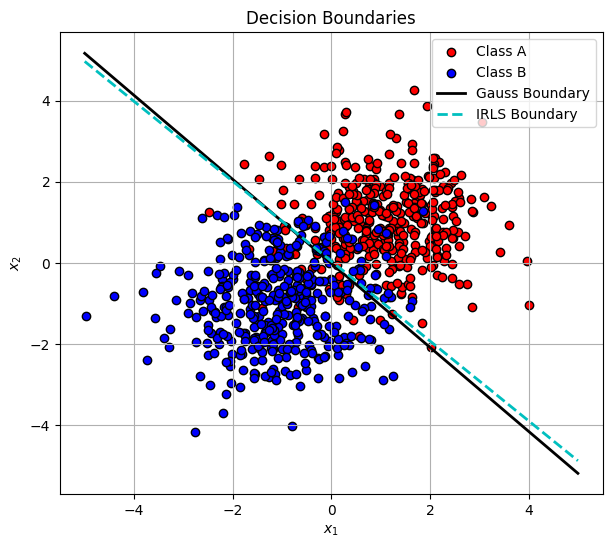

In [8]:
# Plot data generated
plt.figure(figsize=(7,6))
plt.scatter(X1[:,0], X1[:,1], color='red', edgecolor='k', label='Class A')
plt.scatter(X2[:,0], X2[:,1], color='blue', edgecolor='k', label='Class B')

# X1 values for decision boundary visualization
x1_vals = np.linspace(-5, 5, 100)

# GDA decision boundary found from our linear eq: w0 + w1*x1 + w2*x2 = 0
x2_gauss = -(w_gauss[0] + w_gauss[1]*x1_vals) / w_gauss[2]

# IRLS decision boundary found from our linear eq
x2_irls = -(w_irls[0] + w_irls[1]*x1_vals) / w_irls[2]

plt.plot(x1_vals, x2_gauss, 'k-', linewidth=2, label='Gauss Boundary')
plt.plot(x1_vals, x2_irls, 'c--', linewidth=2, label='IRLS Boundary')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision Boundaries')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Breast Cancer Dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes) 
X_uci = breast_cancer_wisconsin_diagnostic.data.features 
y_uci = breast_cancer_wisconsin_diagnostic.data.targets 

# Convert pandas data to numpy arrays
X_bdata = X_uci.to_numpy()

y = y_uci['Diagnosis'].to_numpy()
y_bdata = np.where(y == 'M', 1, 0) #Convert M or B to 1/0 for classification)

bdata_prob_A = np.mean(y_bdata == 1) # Prior Probability of Class A
bdata_prob_B = np.mean(y_bdata == 0) # Prior Probability of Class B
sigma_bdata = np.eye(30) #New Variance matrix

In [10]:
# Gaussian Generative Model for Breast Cancer- Assume the underlying Class samples were generated from a Gaussian Dist.
bdata_mu1 = X_bdata[y_bdata==1].mean(axis=0) # Mean across all samples in Class A --> returns a 30-dim vector (one mean per feature).
bdata_mu2 = X_bdata[y_bdata==0].mean(axis=0) # Mean across all samples in Class B --> returns a 30-dim vector (one mean per feature).

w_bdata_gauss, y_pred_bdata_gauss_raw = posterior_prob(X_bdata, bdata_mu1, bdata_mu2, sigma_bdata, bdata_prob_A, bdata_prob_B) 
y_pred_bdata_gauss = (y_pred_bdata_gauss_raw > 0.5).astype(int) # Model Classification (greater than 0.5 since its decision) 
# Make sure 0.5 is always the threshold
#Check if Classified same as true Y
accuracy_b = np.mean(y_pred_bdata_gauss == y_bdata)

print(f"Gauss Gen Accuracy: {accuracy_b:.2f}")

Gauss Gen Accuracy: 0.89


In [11]:
# Logistic Regression IRSL Model Performance for Breast Cancer
iterations = 30
w_old_bdata = np.zeros(31) # initially set weight vector of size 30 + 1 to 0
w_irls_bdata, y_pred_irls_bdata_raw = step_IRLS(X_bdata, y_bdata, w_old_bdata, iterations) # Model Classification (greater than 0.5 since its decision) 
y_pred_irls_bdata = (y_pred_irls_bdata_raw > 0.5).astype(int)

# Make sure 0.5 is always the threshold
#Check if Classified same as true Y
accuracy_irsl_bdata = np.mean(y_pred_irls_bdata == y_bdata)
#
print(f"Logistic Reg Accuracy: {accuracy_irsl_bdata:.2f}")
#(I think I got lucky with this dataset or something)

Logistic Reg Accuracy: 0.98


[0. 1.]


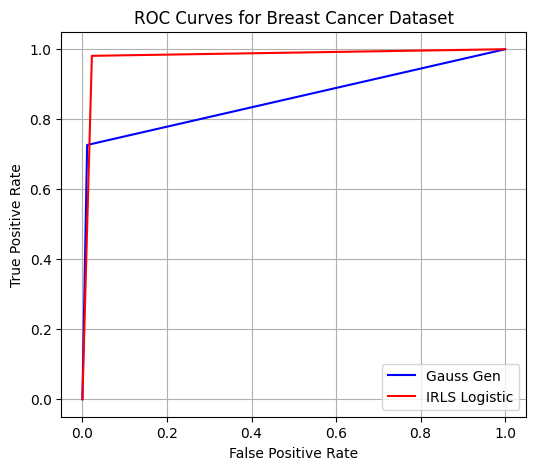

In [17]:
# Plotting ROC Curve
false_pos_gauss_b, true_pos_gauss_b, _ = roc_curve(y_bdata, y_pred_bdata_gauss_raw)
false_pos_irls_b, true_pos_irls_b, _ = roc_curve(y_bdata, y_pred_irls_bdata_raw)

# Plot both ROC curves
plt.figure(figsize=(6, 5))
plt.plot(false_pos_gauss_b, true_pos_gauss_b, label=f'Gauss Gen', color='blue')
plt.plot(false_pos_irls_b, true_pos_irls_b, label=f'IRLS Logistic', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Breast Cancer Dataset')
plt.legend()
plt.grid(True)
plt.show()